Import Data and Packages

In [4]:
import os, sys
dir2 = os.path.abspath('')
dir1 = os.path.dirname(dir2)
if not dir1 in sys.path: sys.path.append(dir1)
original = pd.read_csv('../Data/podcast_dataset.csv')

import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.impute import SimpleImputer
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from Helper.data import load_data
from tqdm import tqdm

NameError: name 'pd' is not defined

Filter Outliers

In [ ]:
train, test = load_data()
train = train[(train["Number_of_Ads"] < 10) | (train["Number_of_Ads"].isna())]
train = train[(train["Episode_Length_minutes"] < 300) | (train["Episode_Length_minutes"].isna())]
train = train[(train["Host_Popularity_percentage"] < 100) | (train["Host_Popularity_percentage"].isna())]
train = train[(train["Guest_Popularity_percentage"] < 100) | (train["Guest_Popularity_percentage"].isna())]

Feature Engineering

In [ ]:
TARGET = 'Listening_Time_minutes'

CATS = ['Podcast_Name', 'Episode_Title', 'Genre', 'Publication_Day', 'Publication_Time', 'Episode_Sentiment']

NUMS = ['Episode_Length_minutes', 'Host_Popularity_percentage', 
        'Guest_Popularity_percentage', 'Number_of_Ads']
FEATURES = NUMS + CATS

In [ ]:
train_counts = train.nunique().reset_index()
train_counts.columns = ['Column', 'Train Unique']
test_counts = test.nunique().reset_index()
test_counts.columns = ['Column', 'Test Unique']
original_counts = original.nunique().reset_index()
original_counts.columns = ['Column', 'Original Unique']
merged_counts = pd.merge(train_counts, test_counts, on='Column', how='outer')
merged_counts = pd.merge(merged_counts, original_counts, on='Column', how='outer')
merged_counts

,Column,Train Unique,Test Unique,Original Unique
0,Episode_Length_minutes,12267,11631.0,11297.0
1,Episode_Sentiment,3,3.0,3.0
2,Episode_Title,100,100.0,100.0
3,Genre,10,10.0,10.0
4,Guest_Popularity_percentage,10003,9961.0,9899.0
5,Host_Popularity_percentage,8019,8010.0,7976.0
6,Listening_Time_minutes,42807,NaN,42909.0
7,Number_of_Ads,4,6.0,4.0
8,Podcast_Name,48,48.0,48.0
9,Publication_Day,7,7.0,7.0


Target Encoding

In [ ]:
m = train[TARGET].mean()

ORIG_TARGET = []

for c in FEATURES:
    n = f"{c}2"
    ORIG_TARGET.append(n)  
    
    # Get target encoding mapping from original data
    target_mapping = original.groupby(c)[TARGET].mean()
    
    # Apply mapping to train and test
    if train[c].dtype.name == 'category':
        # For categorical columns, convert to string first
        train[n] = train[c].astype(str).map(target_mapping)
        test[n] = test[c].astype(str).map(target_mapping)
    else:
        # For non-categorical columns
        train[n] = train[c].map(target_mapping)
        test[n] = test[c].map(target_mapping)
    
    # Fill NA values
    train[n] = train[n].fillna(m)
    test[n] = test[n].fillna(m)

train.head(3)

,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,...,Episode_Length_minutes2,Host_Popularity_percentage2,Guest_Popularity_percentage2,Number_of_Ads2,Podcast_Name2,Episode_Title2,Genre2,Publication_Day2,Publication_Time2,Episode_Sentiment2
0,0,Mystery Matters,Episode 98,NaN,True Crime,74.81,Thursday,Night,NaN,0.0,...,45.436281,43.420073,45.436281,48.525459,46.143074,43.525145,46.551083,45.545049,45.902440,46.940936
1,1,Joke Junction,Episode 26,119.8,Comedy,66.95,Saturday,Afternoon,75.95,2.0,...,87.105517,43.957970,36.098898,44.321965,43.651926,45.260247,44.524182,45.194999,45.937834,44.654776
2,2,Study Sessions,Episode 16,73.9,Education,69.97,Tuesday,Evening,8.97,0.0,...,59.046850,39.812068,36.644250,48.525459,45.938614,44.309041,45.222056,46.273659,44.989281,44.654776


In [ ]:
def extract_episode_number(episode_title):
    """Extract episode number from episode title string."""
    try:
        # Use string split to get the part after "Episode "
        return int(episode_title.split("Episode ")[1])
    except (IndexError, ValueError):
        # Return NaN if extraction fails
        return np.nan

# Create a new feature for episode number
train['Episode_Number'] = train_encoded_original['Episode_Title'].apply(extract_episode_number)

# Do the same for test set if needed
if 'test' in locals() or 'test' in globals():
    # For test set, episode titles might be already encoded as integers
    if isinstance(test['Episode_Title'].iloc[0], (int, np.integer)):
        test['Episode_Number'] = test['Episode_Title']
    else:
        test['Episode_Number'] = test['Episode_Title'].apply(extract_episode_number)

# Check the distribution of episode numbers
print("Episode number distribution:")
print(train['Episode_Number'].describe())

# Check if there's correlation between episode number and listening time
correlation = train['Episode_Number'].corr(train[TARGET])
print(f"Correlation between Episode_Number and {TARGET}: {correlation:.4f}")

Episode number distribution:
count     749944
unique       100
top           71
freq       10515
Name: Episode_Number, dtype: int64
Correlation between Episode_Number and Listening_Time_minutes: -0.0173
<class 'pandas.core.frame.DataFrame'>
Index: 749944 entries, 0 to 749999
Data columns (total 23 columns):
 #   Column                        Non-Null Count   Dtype   
---  ------                        --------------   -----   
 0   id                            749944 non-null  int64   
 1   Podcast_Name                  749944 non-null  category
 2   Episode_Title                 749944 non-null  category
 3   Episode_Length_minutes        662857 non-null  float64 
 4   Genre                         749944 non-null  category
 5   Host_Popularity_percentage    749944 non-null  float64 
 6   Publication_Day               749944 non-null  category
 7   Publication_Time              749944 non-null  category
 8   Guest_Popularity_percentage   603916 non-null  float64 
 9   Number_of_Ads  

In [ ]:
from itertools import combinations

encode_columns = ['Episode_Length_minutes', 'Episode_Number', 'Host_Popularity_percentage', 'Number_of_Ads', 'Episode_Sentiment', 'Publication_Day', 'Publication_Time']
pair_size = [2,3]

for r in pair_size:
    for cols in tqdm(list(combinations(encode_columns, r))):
        new_col_name = '_'.join(cols)
        
        # Check if all the columns in the combination exist in the DataFrame
        if all(col in train.columns for col in cols):
            train[new_col_name] = train[list(cols)].astype(str).agg('_'.join, axis=1)
            train[new_col_name] = train[new_col_name].astype('category')
        else:
            print(f"Skipping {new_col_name} as one or more columns don't exist in the DataFrame")

100%|██████████| 35/35 [01:28<00:00,  2.52s/it]


In [ ]:
# Create a mask for NaN values in Guest_Popularity_percentage
guest_pop_na_mask = train['Guest_Popularity_percentage'].isna()

# Create a new feature that indicates if Guest_Popularity_percentage is NA
train['Guest_Popularity_NA'] = guest_pop_na_mask.astype(int)

# Do the same for the test set if needed
if 'test' in locals() or 'test' in globals():
    test['Guest_Popularity_NA'] = test['Guest_Popularity_percentage'].isna().astype(int)

# For other NA values in numeric features
for col in ['Episode_Length_minutes', 'Number_of_Ads']:
    if train[col].isna().any():
        train[f'{col}_NA'] = train[col].isna().astype(int)
        if 'test' in locals() or 'test' in globals():
            test[f'{col}_NA'] = test[col].isna().astype(int)

# Print the counts of NAs vs non-NAs for Guest_Popularity_percentage
print(f"Guest Popularity NA counts: {guest_pop_na_mask.sum()}")
print(f"Guest Popularity non-NA counts: {(~guest_pop_na_mask).sum()}")


Guest Popularity NA counts: 146028
Guest Popularity non-NA counts: 603916


In [ ]:
train.head(3)

,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,...,Host_Popularity_percentage_Episode_Sentiment_Publication_Day,Host_Popularity_percentage_Episode_Sentiment_Publication_Time,Host_Popularity_percentage_Publication_Day_Publication_Time,Number_of_Ads_Episode_Sentiment_Publication_Day,Number_of_Ads_Episode_Sentiment_Publication_Time,Number_of_Ads_Publication_Day_Publication_Time,Episode_Sentiment_Publication_Day_Publication_Time,Guest_Popularity_NA,Episode_Length_minutes_NA,Number_of_Ads_NA
0,0,Mystery Matters,Episode 98,NaN,True Crime,74.81,Thursday,Night,NaN,0.0,...,74.81_Positive_Thursday,74.81_Positive_Night,74.81_Thursday_Night,0.0_Positive_Thursday,0.0_Positive_Night,0.0_Thursday_Night,Positive_Thursday_Night,1,1,0
1,1,Joke Junction,Episode 26,119.8,Comedy,66.95,Saturday,Afternoon,75.95,2.0,...,66.95_Negative_Saturday,66.95_Negative_Afternoon,66.95_Saturday_Afternoon,2.0_Negative_Saturday,2.0_Negative_Afternoon,2.0_Saturday_Afternoon,Negative_Saturday_Afternoon,0,0,0
2,2,Study Sessions,Episode 16,73.9,Education,69.97,Tuesday,Evening,8.97,0.0,...,69.97_Negative_Tuesday,69.97_Negative_Evening,69.97_Tuesday_Evening,0.0_Negative_Tuesday,0.0_Negative_Evening,0.0_Tuesday_Evening,Negative_Tuesday_Evening,0,0,0


Training Model

In [1]:
np.random.seed(42)
# features = [col for col in train.columns if col not in ['id', TARGET]]
features = [col for col in train.columns if col not in [TARGET]]
X = train[features]
y = train['Listening_Time_minutes']

# XGBoost-Regressor definieren
model = XGBRegressor(
    enable_categorical=True,
    n_estimators= 100,
    learning_rate=0.02,
    max_depth=11,
    subsample=0.8,
    colsample_bynode=0.6,
    random_state=42,
    verbosity=2,
    n_jobs=-1    
)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

cv_scores = cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=kf)

rmse_scores = np.sqrt(-cv_scores)

print("RMSE pro Fold:", rmse_scores)
print("Durchschnittlicher RMSE:", rmse_scores.mean())


NameError: name 'np' is not defined

12.87

Feature Engineering

In [ ]:
for col in CATS:
    combined = pd.concat([train[col], test[col]], axis=0)
    codes, uniques = pd.factorize(combined)
    train[col] = codes[:len(train)]
    test[col] = codes[len(train):]
    
# Define the selected interaction features based on my local forward selection:
SELECTED_INTERACT = [
    'Episode_Length_minutes_Host_Popularity_percentage', 
    'Episode_Length_minutes_Guest_Popularity_percentage', 
    'Episode_Length_minutes_Number_of_Ads', 
    'Episode_Length_minutes_Publication_Time', 
    'Episode_Length_minutes_Episode_Sentiment', 
    'Host_Popularity_percentage_Guest_Popularity_percentage', 
    'Host_Popularity_percentage_Number_of_Ads', 
    'Host_Popularity_percentage_Podcast_Name', 
    'Host_Popularity_percentage_Publication_Time', 
    'Host_Popularity_percentage_Episode_Sentiment', 
    'Guest_Popularity_percentage_Number_of_Ads', 
    'Guest_Popularity_percentage_Publication_Day', 
    'Guest_Popularity_percentage_Publication_Time', 
    'Guest_Popularity_percentage_Episode_Sentiment', 
    'Episode_Title_Episode_Sentiment'
]

# Create the selected interaction features for both train and test.
for candidate in SELECTED_INTERACT:
    c1, c2 = None, None
    for f in FEATURES:
        prefix = f + '_'
        if candidate.startswith(prefix):
            possible_c2 = candidate[len(prefix):]
            if possible_c2 in FEATURES:
                c1 = f
                c2 = possible_c2
                break
    if c1 is None or c2 is None:
        raise ValueError(f"Unable to parse the candidate feature '{candidate}' into two base features.")
    
    # Create the interaction feature as the product of the two columns.
    train[candidate] = train[c1] * train[c2]
    test[candidate] = test[c1] * test[c2]

print("Selected interaction features have been created in both train and test.")

Selected interaction features have been created in both train and test.


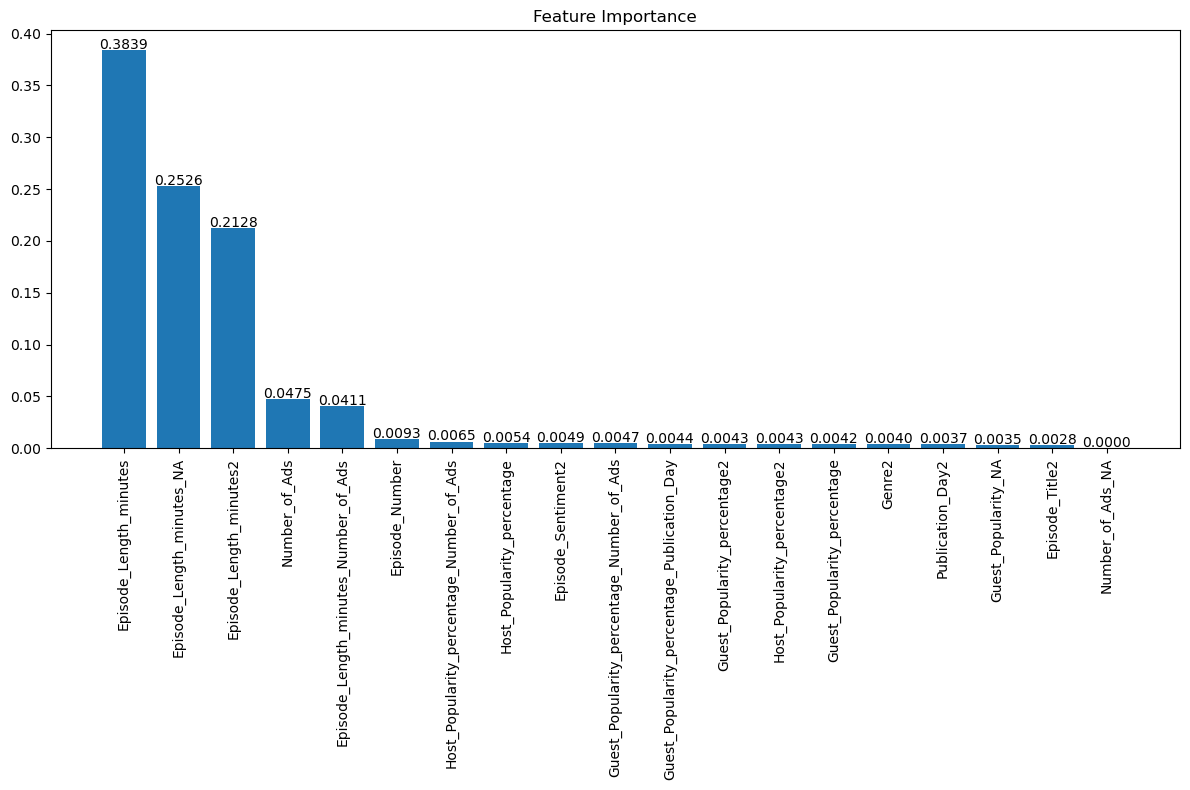


Feature Importance (Top 15):
Episode_Length_minutes                  : 0.3839
Episode_Length_minutes_NA               : 0.2526
Episode_Length_minutes2                 : 0.2128
Number_of_Ads                           : 0.0475
Episode_Length_minutes_Number_of_Ads    : 0.0411
Episode_Number                          : 0.0093
Host_Popularity_percentage_Number_of_Ads: 0.0065
Host_Popularity_percentage              : 0.0054
Episode_Sentiment2                      : 0.0049
Guest_Popularity_percentage_Number_of_Ads: 0.0047
Guest_Popularity_percentage_Publication_Day: 0.0044
Guest_Popularity_percentage2            : 0.0043
Host_Popularity_percentage2             : 0.0043
Guest_Popularity_percentage             : 0.0042
Genre2                                  : 0.0040


In [126]:

import matplotlib.pyplot as plt

model.fit(X, y)

# Get feature importance
importance = model.feature_importances_
feature_names = features

# Sort features by importance
indices = np.argsort(importance)[::-1]
sorted_importance = importance[indices]
sorted_features = [feature_names[i] for i in indices]

# Plot feature importance
plt.figure(figsize=(12, 8))
plt.title('Feature Importance')
plt.bar(range(len(sorted_importance)), sorted_importance, align='center')
plt.xticks(range(len(sorted_importance)), sorted_features, rotation=90)
plt.tight_layout()

# Adding values on top of bars
for i, v in enumerate(sorted_importance):
    plt.text(i, v + 0.001, f"{v:.4f}", ha='center')

plt.show()

# Print feature importance in tabular format
print("\nFeature Importance (Top 15):")
for i in range(min(15, len(sorted_features))):
    print(f"{sorted_features[i]:<40}: {sorted_importance[i]:.4f}")

Feature Selection

In [27]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 749944 entries, 0 to 749999
Data columns (total 37 columns):
 #   Column                                                  Non-Null Count   Dtype  
---  ------                                                  --------------   -----  
 0   id                                                      749944 non-null  int64  
 1   Podcast_Name                                            749944 non-null  int64  
 2   Episode_Title                                           749944 non-null  int64  
 3   Episode_Length_minutes                                  662857 non-null  float64
 4   Genre                                                   749944 non-null  int64  
 5   Host_Popularity_percentage                              749944 non-null  float64
 6   Publication_Day                                         749944 non-null  int64  
 7   Publication_Time                                        749944 non-null  int64  
 8   Guest_Popularity_percentage  

In [28]:
import numpy as np
import pandas as pd
from xgboost import XGBRegressor
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.model_selection import KFold, cross_val_score

# Reproduzierbarkeit
np.random.seed(42)

# Exclude categorical columns that haven't been encoded yet and the target variable
excluded_cols = ['id', TARGET, 'Podcast_Name', 'Episode_Title', 'Genre', 'Publication_Day', 'Publication_Time', 'Episode_Sentiment']

# Select numeric features only (target encoded and interaction features are already numeric)
features = [col for col in train.columns if col not in excluded_cols]
X = train[features]
y = train['Listening_Time_minutes']

# Definiere das Modell
model = XGBRegressor(
    tree_method='hist',
    enable_categorical=True,
    n_estimators= 10,
    learning_rate=0.02,
    max_depth=11,
    subsample=0.8,
    colsample_bynode=0.6,
    random_state=42,
    verbosity=2,
    n_jobs=-1    
)

# KFold-Cross-Validation für stabile Schätzungen
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Forward Selection: Startet mit einem leeren Featureset und fügt in jedem Schritt das Feature hinzu,
# das den besten CV-Score erzielt.
sfs = SFS(model,
          k_features='best',  # Alternativ k_features kann auch eine Zahl sein, z.B. 10
          forward=True,
          floating=False,
          scoring='neg_mean_squared_error',  # Wir verwenden neg. MSE als Bewertungsmetrik
          cv=cv,
          n_jobs=1,
          verbose = 2)  # Serielle Ausführung um Pickling-Probleme zu vermeiden

# Fit des Selektors auf die Daten
sfs = sfs.fit(X, y)

# Zusammenfassung der ausgewählten Features
selected_features = list(sfs.k_feature_names_)
print("Ausgewählte Features:", selected_features)

# Optional: Bewertung der Modellgüte mit diesen Features
X_selected = sfs.transform(X)
scores = cross_val_score(model, X_selected, y, scoring='neg_mean_squared_error', cv=cv)
rmse_scores = np.sqrt(-scores)
print("RMSE Scores:", rmse_scores)
print("Durchschnittlicher RMSE:", rmse_scores.mean())


[2025-04-11 18:06:42] Features: 1/29 -- score: -552.288111532793
[2025-04-11 18:07:09] Features: 2/29 -- score: -552.3033942609097
[2025-04-11 18:07:38] Features: 3/29 -- score: -551.869933644696
[2025-04-11 18:08:15] Features: 4/29 -- score: -549.8751037242688
[2025-04-11 18:08:57] Features: 5/29 -- score: -549.4707000918685
[2025-04-11 18:09:38] Features: 6/29 -- score: -549.4557297594808
[2025-04-11 18:10:22] Features: 7/29 -- score: -549.2983823006032
[2025-04-11 18:11:07] Features: 8/29 -- score: -549.360444208417
[2025-04-11 18:11:53] Features: 9/29 -- score: -549.2787063236754
[2025-04-11 18:12:41] Features: 10/29 -- score: -549.2629423560954
[2025-04-11 18:13:31] Features: 11/29 -- score: -549.2631847873274
[2025-04-11 18:14:20] Features: 12/29 -- score: -549.2503475029613
[2025-04-11 18:15:08] Features: 13/29 -- score: -549.2727447098348
[2025-04-11 18:15:57] Features: 14/29 -- score: -549.2573225179156
[2025-04-11 18:16:44] Features: 15/29 -- score: -549.1945396356457
[2025-

Ausgewählte Features: ['Episode_Length_minutes', 'Host_Popularity_percentage', 'Guest_Popularity_percentage', 'Number_of_Ads', 'Episode_Length_minutes2', 'Host_Popularity_percentage2', 'Guest_Popularity_percentage2', 'Episode_Title2', 'Genre2', 'Publication_Day2', 'Episode_Sentiment2', 'Episode_Length_minutes_Number_of_Ads', 'Host_Popularity_percentage_Number_of_Ads', 'Guest_Popularity_percentage_Number_of_Ads', 'Guest_Popularity_percentage_Publication_Day']
RMSE Scores: [23.51341808 23.42873451 23.45161691 23.3995327  23.38097092]
Durchschnittlicher RMSE: 23.434854624850317


In [ ]:
FEATURES = ['Episode_Length_minutes', 'Host_Popularity_percentage', 'Guest_Popularity_percentage', 'Number_of_Ads', 'Episode_Length_minutes2', 'Host_Popularity_percentage2', 'Guest_Popularity_percentage2', 'Episode_Title2', 'Genre2', 'Publication_Day2', 'Episode_Sentiment2', 'Episode_Length_minutes_Number_of_Ads', 'Host_Popularity_percentage_Number_of_Ads', 'Guest_Popularity_percentage_Number_of_Ads', 'Guest_Popularity_percentage_Publication_Day']
X = train[FEATURES]
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 749944 entries, 0 to 749999
Data columns (total 15 columns):
 #   Column                                       Non-Null Count   Dtype  
---  ------                                       --------------   -----  
 0   Episode_Length_minutes                       662857 non-null  float64
 1   Host_Popularity_percentage                   749944 non-null  float64
 2   Guest_Popularity_percentage                  603916 non-null  float64
 3   Number_of_Ads                                749943 non-null  float64
 4   Episode_Length_minutes2                      749944 non-null  float64
 5   Host_Popularity_percentage2                  749944 non-null  float64
 6   Guest_Popularity_percentage2                 749944 non-null  float64
 7   Episode_Title2                               749944 non-null  float64
 8   Genre2                                       749944 non-null  float64
 9   Publication_Day2                             749944 non-null  fl